# From Linear Regression in NumPy to Logistic Regression in PyTorch

## Goals

- Compare implementing regression in NumPy vs PyTorch
- Extend regression to classification by adding softmax and cross-entropy
- Practice working with PyTorch's basic APIs

## Setup

Let's import necessary modules: *pandas* and NumPy for data wrangling, Matplotlib for plotting, and some sklearn utilities. Now we'll also be importing PyTorch.

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
import scipy.optimize

# This utility function (inspired by https://github.com/HIPS/autograd/blob/master/autograd/misc/flatten.py)
# is useful for optimizing using scipy.optimize.minimize.
def flatten(arrs):
    """Return a 1D array containing the elements of the input arrays,
    and an unflatten function that takes a flattened array and returns
    the original arrays.
    """
    arrs = [np.asarray(arr) for arr in arrs]
    shapes = [arr.shape for arr in arrs]
    flat = np.concatenate([arr.ravel() for arr in arrs])
    start_indices = np.cumsum([0] + [arr.size for arr in arrs])
    def unflatten(params):
        return [params[start_indices[i]:start_indices[i+1]].reshape(shape)
                for i, shape in enumerate(shapes)]
    return flat, unflatten


We'll load the data as before.

In [2]:
ames = pd.read_csv('https://github.com/kcarnold/AmesHousing/blob/master/data/ames.csv.gz?raw=true', compression="gzip")
ames['price'] = ames["Sale_Price"] / 100_000 # Make `price` be in units of $100k, to be easier to interpret.

# Create price categories (0, 1, or 2) for the classification task
n_classes = 3
ames['price_rank'] = ames['price'].rank(pct=True)
ames['price_bin'] = pd.cut(ames['price_rank'], bins=n_classes, labels=False)

# Prepare features and target
feature_names = ['Longitude', 'Latitude']
X = ames[feature_names].values
y = ames['price_bin'].values

# standardize the features, to make the optimization more stable
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X = (X - X_mean) / X_std

# Split data
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

### Basic EDA

Histogram of target values:

price_bin
0    981
1    980
2    969
Name: count, dtype: int64

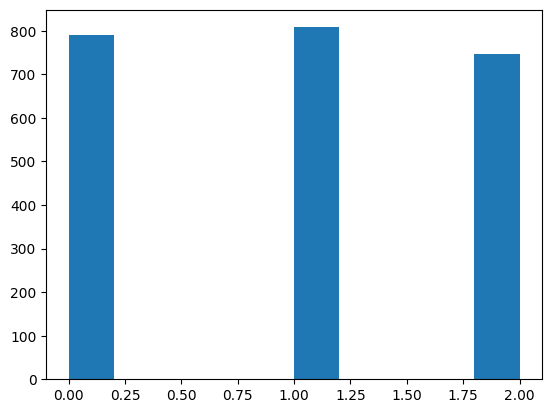

In [3]:
plt.hist(y_train);
ames['price_bin'].value_counts()

Check shapes

In [4]:
print(f"train: X.shape={X_train.shape}, y.shape={y_train.shape}")
print(f"valid: X.shape={X_valid.shape}, y.shape={y_valid.shape}")

train: X.shape=(2344, 2), y.shape=(2344,)
valid: X.shape=(586, 2), y.shape=(586,)


Histogram of input feature values

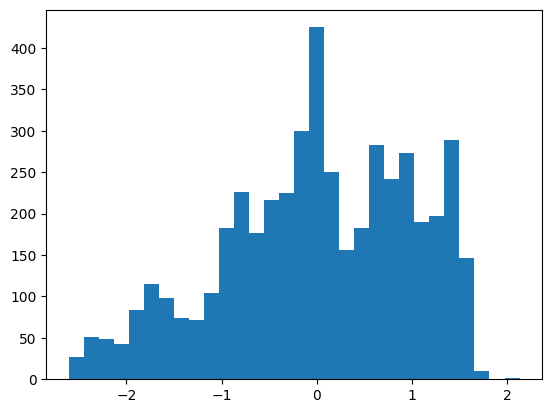

In [5]:
plt.hist(X_train.flatten(), bins=30);

## Part 1: Classification the wrong way (using linear regression)

Let's start by treating this as a regression problem - predicting the class number (0, 1, or 2) directly. We'll fit a linear regression model to the target as if it were a continuous variable. **This isn't the right way to do it**, but it will help us build up to the correct way.

### 1.A Using NumPy

You've seen the code below already. Fill in the blanks to complete the linear regression model in NumPy.

In [18]:
# Initialize parameters
np.random.seed(42)
n_samples, n_features = X_train.shape

initial_weights = np.random.standard_normal(size=(2,)) # 2 for each feature (Lon, Lat)
initial_bias = np.random.standard_normal()

def linear_forward(X, weights, bias):
    return X @ weights + bias

def compute_mse_loss(y_true, y_pred):
    return ((y_true - y_pred) ** 2).mean()

def loss_given_params(params, X, y_true):
    weights, bias = unpack_params(params)
    y_pred = linear_forward(X, weights, bias)
    return compute_mse_loss(y_true, y_pred)

initial_params, unpack_params = flatten([initial_weights, initial_bias])
initial_loss = loss_given_params(initial_params, X_train, y_train)
optimization_result = scipy.optimize.minimize(loss_given_params, initial_params,
                                              args=(X_train, y_train))
fitted_weights_np, fitted_bias_np = unpack_params(optimization_result.x)
print(f"Initial loss: {initial_loss:.2f}")
print(f"Final loss: {optimization_result.fun:.2f}")
print(f"Fitted weights: {fitted_weights_np}")
print(f"Fitted bias: {fitted_bias_np}")

Initial loss: 1.33
Final loss: 0.56
Fitted weights: [-0.26364467  0.17475394]
Fitted bias: 0.9886359240307222


Let's evaluate the "accuracy" of this model. We'll round the predictions to the nearest integer to get the predicted class.

In [8]:
y_pred_valid = linear_forward(X_valid, fitted_weights_np, fitted_bias_np).round()
y_pred_valid[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [9]:
accuracy = (y_pred_valid == y_valid).mean()
print(f"Validation accuracy for linear regression 'classifier': {accuracy:.2f}")

Validation accuracy for linear regression 'classifier': 0.31


### 1.B: Using PyTorch

Now we'll implement the same (wrong) model in PyTorch.

We'll build this together step by step. Notice that we're still doing this "the wrong way", as regression, not classification.

In [22]:
# Convert data to PyTorch tensors
X_train_torch = torch.tensor(X_train, dtype=torch.float32)
X_valid_torch = torch.tensor(X_valid, dtype=torch.float32)
# Note: still treating as regression
y_train_torch = torch.tensor(y_train, dtype=torch.float32)
y_valid_torch = torch.tensor(y_valid, dtype=torch.float32)

class SimpleLinear(nn.Module):
    def __init__(self, n_features):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(n_features))
        self.bias = nn.Parameter(torch.randn(1))
    
    def forward(self, x):
        return x @ self.weights + self.bias

# Training loop
model = SimpleLinear(n_features)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

n_epochs = 100  # epoch--number of times through the training set
for epoch in range(n_epochs):
    # Forward pass
    y_pred = model(X_train_torch)
    loss = F.mse_loss(y_pred, y_train_torch)
    
    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch:02d}, Loss: {loss.item():.4f}')

Epoch 00, Loss: 3.0010
Epoch 10, Loss: 0.5888
Epoch 20, Loss: 0.5575
Epoch 30, Loss: 0.5571
Epoch 40, Loss: 0.5571
Epoch 50, Loss: 0.5571
Epoch 60, Loss: 0.5571
Epoch 70, Loss: 0.5571
Epoch 80, Loss: 0.5571
Epoch 90, Loss: 0.5571


## Part 2: Converting to Classification

Now we're going to switch to doing it the right way, as a classification problem. We'll use the softmax function to convert the model's outputs into probabilities, and the cross-entropy loss to train the model to be least surprised by the true class.

Again we'll start off by implementing this in NumPy, and then extend it to PyTorch.

### 2.A Using NumPy (we'll do this together)

Let's modify our NumPy implementation to:

1. Output one number per class (logits)
2. Convert logits to probabilities using softmax
3. Use cross-entropy loss instead of MSE

We'll start by using one-hot encoding for the outputs, which will make it easy to implement the cross-entropy loss.

In [11]:
# np.eye is the identity matrix; each row is a one-hot vector.
# this code pulls out the one-hot vectors corresponding to the target values
y_train_onehot = np.eye(n_classes)[y_train]
y_valid_onehot = np.eye(n_classes)[y_valid]

y_train_onehot[:5]

array([[0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]])

Now we'll implement softmax and cross-entropy together.

In [48]:
def softmax(logits):
    """Convert logits to probabilities."""
    num_samples, num_classes = logits.shape

    max_logit = logits.max(axis=1, keepdims=True)

    exp_logits = np.exp(logits - max_logit)
    assert exp_logits.shape == (num_samples, num_classes)

    sum_exp_logits = exp_logits.sum(axis=1, keepdims=True)
    assert sum_exp_logits.shape == (num_samples, 1)
    return exp_logits / sum_exp_logits

def cross_entropy_loss(y_true_onehot, probs):
    """Compute cross entropy loss."""
    # Strategy:
    # - Compute log probabilities
    # - Multiply by one-hot vectors and sum, to extract the log probabilities of the true classes
    # - Take the negative to get the loss
    # - Average the loss over the samples

    log_probs = np.log(probs + 1e-6) # add a small value to avoid log(0)
    loss_per_sample = -np.sum(y_true_onehot * log_probs, axis=1)
    assert loss_per_sample.shape == (len(y_true_onehot),)
    return -np.mean(y_true_onehot * log_probs)


In [49]:
# copy and paste the NumPy code block here and we'll edit.
# Initialize parameters
np.random.seed(42)
n_samples, n_features = X_train.shape

initial_weights = np.random.standard_normal(size=(2, 3)) # num of features by num of classes
initial_bias = np.random.standard_normal(size=3)  # a number for each class

def linear_forward(X, weights, bias):
    return X @ weights + bias

In [56]:
def loss_given_params(params, X, y_true_onehot):
    weights, bias = unpack_params(params)
    y_pred = linear_forward(X, weights, bias)
    logits = linear_forward(X, weights, bias)
    probs = softmax(logits)
    return cross_entropy_loss(y_true_onehot, probs)

initial_params, unpack_params = flatten([initial_weights, initial_bias])
initial_loss = loss_given_params(initial_params, X_train, y_train_onehot)
optimization_result = scipy.optimize.minimize(loss_given_params, initial_params,
                                              args=(X_train, y_train_onehot))
fitted_weights_np, fitted_bias_np = unpack_params(optimization_result.x)
print(f"Initial loss: {initial_loss:.2f}")
print(f"Final loss: {optimization_result.fun:.2f}")
print(f"Fitted weights: {fitted_weights_np}")
print(f"Fitted bias: {fitted_bias_np}")

Initial loss: 0.64
Final loss: 0.34
Fitted weights: [[ 0.77536606  0.39968742 -0.16891526]
 [ 0.01591506  0.34059967  0.6982245 ]]
Fitted bias: [0.61373843 0.75166814 0.51176642]


Now let's compute the accuracy again.

In [57]:
y_pred_valid_logits = linear_forward(X_valid, fitted_weights_np, fitted_bias_np)
y_pred_valid = y_pred_valid_logits.argmax(axis=1)
y_pred_valid[:10]

array([0, 1, 2, 2, 0, 2, 0, 1, 2, 2])

In [58]:
accuracy = (y_pred_valid == y_valid).mean()
print(f"Validation accuracy for logistic regression: {accuracy:.2f}")

Validation accuracy for logistic regression: 0.52


### 2.B Using PyTorch

We'll first walk through the PyTorch primitives together, then you'll modify the PyTorch code from Part 1 to use these primitives.

In [59]:
y_train_longtensor = torch.tensor(y_train)
y_valid_longtensor = torch.tensor(y_valid)

#### Setting up the linear layer

Fill in the blanks below with the correct number of features.

In [62]:
linear_layer = nn.Linear(in_features=2, out_features=3, bias=True)
logits = linear_layer(X_train_torch)
logits.shape

torch.Size([2344, 3])

#### Softmax

PyTorch has builtin functionality for softmax. We can use it like this:

In [63]:
probs = logits.softmax(axis=1)
probs.shape

torch.Size([2344, 3])

Let's check that the probabilities sum to 1 for each row. Think about what axis you should use for the sum. *General sum rule: whatever axis we sum over will be the axis that disappears.*

In [64]:
probs_sums = probs.sum(axis=1)
probs_sums.shape

torch.Size([2344])

In [65]:
probs_sums[:10]

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], grad_fn=<SliceBackward0>)

#### Cross-entropy loss

There are a few different ways we could implement a categorical cross-entropy loss in PyTorch; notice that they give the same output. The `F.cross_entropy` approach is most efficient and numerically stable because **it combines the softmax operation, one-hot encoding, and the cross-entropy loss** into a single step.

In [66]:
# Direct approach, analogous to the NumPy code above
y_train_onehot_torch = torch.tensor(y_train_onehot, dtype=torch.int64)
log_probs = probs.log()
-(y_train_onehot_torch * log_probs).sum(axis=1).mean()

tensor(1.0945, grad_fn=<NegBackward0>)

In [67]:
# cross-entropy loss function in PyTorch uses logits (without softmax) and class indices (without one-hot)
F.cross_entropy(logits, y_train_longtensor)

tensor(1.0945, grad_fn=<NllLossBackward0>)

<details> 
  <summary>Other ways to compute cross-entropy loss</summary>

```python
 # see also F.one_hot if you're curious.
F.nll_loss(log_probs, y_train_longtensor)
F.nll_loss(logits.log_softmax(axis=1), y_train_longtensor)

# using the "object-oriented" interface
loss_fn = nn.CrossEntropyLoss()
loss_fn(logits, y_train_longtensor)
```
</details>

#### Full PyTorch Implementation

**Your turn**: Copy and paste your PyTorch linear regression code here and make it into a logistic regression by modifying it to use softmax and cross-entropy loss.


In [75]:
# Convert data to PyTorch tensors
X_train_torch = torch.tensor(X_train, dtype=torch.float32)
X_valid_torch = torch.tensor(X_valid, dtype=torch.float32)

y_train_torch = torch.tensor(y_train, dtype=torch.float32)
y_valid_torch = torch.tensor(y_valid, dtype=torch.float32)

# Training loop
linear_layer = nn.Linear(in_features=2, out_features=3, bias=True)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

n_epochs = 100  # epoch--number of times through the training set
for epoch in range(n_epochs):
    # Forward pass
    logits = linear_layer(X_train_torch)
    probs = logits.softmax(axis=1)
    loss = F.cross_entropy(probs, y_train_longtensor)
    
    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch:02d}, Loss: {loss.item():.4f}')

Epoch 00, Loss: 1.0524
Epoch 10, Loss: 1.0524
Epoch 20, Loss: 1.0524
Epoch 30, Loss: 1.0524
Epoch 40, Loss: 1.0524
Epoch 50, Loss: 1.0524
Epoch 60, Loss: 1.0524
Epoch 70, Loss: 1.0524
Epoch 80, Loss: 1.0524
Epoch 90, Loss: 1.0524


### Looking ahead: a multi-layer network

Just as a preview for where we're going next week:

In [76]:
n_hidden = 100
model = nn.Sequential(
    nn.Linear(in_features=n_features, out_features=n_hidden, bias=True),
    nn.ReLU(),
    nn.Linear(in_features=n_hidden, out_features=n_classes, bias=True),
)

optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

n_epochs = 1000
for epoch in range(n_epochs):
    # Forward pass
    logits = model(X_train_torch)
    loss = F.cross_entropy(logits, y_train_longtensor)
    
    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch:03d}, Loss: {loss.item():.4f}')

# Evaluate on validation set
logits_valid = model(X_valid_torch)
y_pred_valid = logits_valid.argmax(dim=1)
accuracy = (y_pred_valid == y_valid_longtensor).float().mean()
print(f'Validation accuracy: {accuracy.item():.2f}')

Epoch 000, Loss: 1.0985
Epoch 010, Loss: 1.0176
Epoch 020, Loss: 0.9951
Epoch 030, Loss: 0.9783
Epoch 040, Loss: 0.9645
Epoch 050, Loss: 0.9529
Epoch 060, Loss: 0.9430
Epoch 070, Loss: 0.9346
Epoch 080, Loss: 0.9273
Epoch 090, Loss: 0.9211
Epoch 100, Loss: 0.9157
Epoch 110, Loss: 0.9109
Epoch 120, Loss: 0.9068
Epoch 130, Loss: 0.9030
Epoch 140, Loss: 0.8997
Epoch 150, Loss: 0.8968
Epoch 160, Loss: 0.8941
Epoch 170, Loss: 0.8916
Epoch 180, Loss: 0.8894
Epoch 190, Loss: 0.8874
Epoch 200, Loss: 0.8856
Epoch 210, Loss: 0.8840
Epoch 220, Loss: 0.8825
Epoch 230, Loss: 0.8811
Epoch 240, Loss: 0.8798
Epoch 250, Loss: 0.8785
Epoch 260, Loss: 0.8774
Epoch 270, Loss: 0.8763
Epoch 280, Loss: 0.8753
Epoch 290, Loss: 0.8743
Epoch 300, Loss: 0.8734
Epoch 310, Loss: 0.8725
Epoch 320, Loss: 0.8716
Epoch 330, Loss: 0.8707
Epoch 340, Loss: 0.8698
Epoch 350, Loss: 0.8690
Epoch 360, Loss: 0.8681
Epoch 370, Loss: 0.8673
Epoch 380, Loss: 0.8666
Epoch 390, Loss: 0.8658
Epoch 400, Loss: 0.8651
Epoch 410, Loss:

## Analysis

Come back to these questions after you've finished the lab.

1. Compare the NumPy and PyTorch implementations. What are the main differences you notice? What are the benefits of PyTorch?

2. We came up with 4 weight matrices in the main part of this exercise (linear regression NumPy and PyTorch, logistic regression NumPy and PyTorch). Which of these matrices had the same shapes? Which ones had the same values? Why?

3. Which of these two models (linear regression vs logistic regression) does better on this task? (Which number would we use to compare them: loss, accuracy, or something else? Why?)

4. Suppose a job interviewer asks you to describe the similarities and differences between linear regression and logistic regression. What would you say? (Hint: discuss how each model makes a prediction, what kinds of patterns in the data they can use, how you measure training progress, etc.

1. The main difference between `Numpy` and `PyTorch` is that PyTorch has a bunch of functions that we don't have to build from scratch (e.g. `cross-entropy` and `softmax`)--it's more convenient. Another difference is with how we're representing data. In Numpy we're using arrays whereas in PyTorch we utilize `tensors`.
2. `blank`
3. The `Logistic Regression Model` performs the best. The metric we use to make this conclusion is the accuracy. We can also use loss to tell which worked better because even when both models started from the same point, the loss was a lot less in `Logistic Reg Model` than the `Linear Model`.
4. Both methods utilize the same `forward pass` technique to a **point**--specifically the sum of the product (of the training data, and weight) with the bias. However, where they differ is how they calculate loss. With linear regression we are dealing with numerical (continuous) samples; hence why we metrics such as MSE or MAE. In contrast, the logistic regression works with **discrete** classes. Here we're focused on metrics such as **accuracy**.